In [2]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../')
from ARGUSUtils_Transforms import *

In [3]:
device_num = 2

img1_dir = "../../Data/Final15/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.nii.gz')))

num_folds = 15

num_classes = 3

max_epochs = 1000

net_dims = 3
net_in_channels = 1
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)

num_workers_tr = 4
batch_size_tr = 8
num_workers_vl = 2
batch_size_vl = 2

num_slices = 48
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-3D-PR-Final15-Full"

In [4]:
if not os.path.exists(model_filename_base):
    os.mkdir(model_filename_base)

model_filename_base = model_filename_base+"/"

In [5]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns_image_60','218ns_image_63','219ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

train_files =  []
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in ns_prefix)],
        [se for se in all_labels if any(pref in se for pref in ns_prefix)])
    ])
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in s_prefix)],
        [se for se in all_labels if any(pref in se for pref in s_prefix)])
    ])
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in ns_prefix)],
        [se for se in all_labels if any(pref in se for pref in ns_prefix)])
    ])
train_files = list(np.concatenate(train_files).flat)
print(len(train_files))

Num images / labels = 47 47
62


../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.interpolated-overlay.nii.gz
Labels =  0 - 2


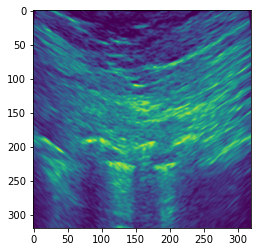

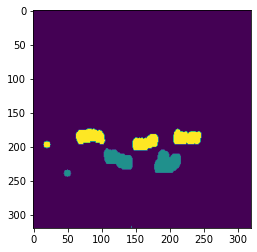

In [6]:
imgnum = 0 #30 for s, 0 for ns

print(train_files[imgnum]["image"])
print(train_files[imgnum]["label"])

img = itk.imread(train_files[imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])
print("Labels = ", arrlbl[:,:,:].min(), "-", arrlbl[:,:,:].max())

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['trilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image', 'label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            center_slice=30,
            axis=3,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [8]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
train_loader = DataLoader(train_ds, batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 

Loading dataset: 100%|██████████████████████████| 62/62 [00:03<00:00, 17.48it/s]


torch.Size([8, 1, 320, 320, 48])
torch.Size([1, 320, 320, 48])
image shape: torch.Size([1, 320, 320, 48]), label shape: torch.Size([1, 320, 320, 48])


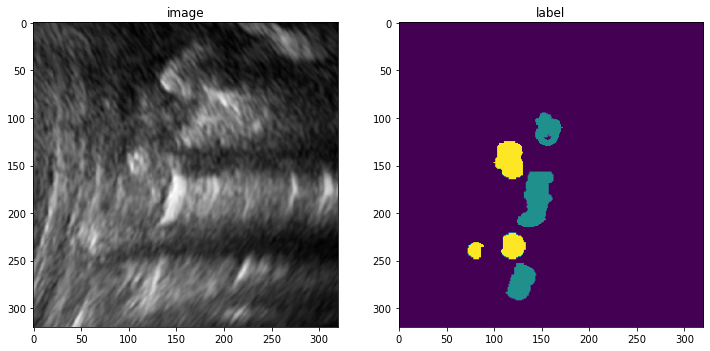

tensor(0.) tensor(2.)


In [9]:
imgnum = 0
check_data = first(train_loader)
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, 24], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 24])
plt.show()
print(label.min(), label.max())

In [10]:
device = torch.device("cuda:"+str(device_num))

In [11]:
def net_train(train_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"Epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in train_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2]+metric_values[-3])/3
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'best_model.pth')
                        print("saved new best metric model")
                if epoch == max_epochs // 3:
                    torch.save(model.state_dict(), model_filename_base+'Epoch'+str(epoch)+'_model.pth')
                if epoch == (2*max_epochs) // 3:
                    torch.save(model.state_dict(), model_filename_base+'Epoch'+str(epoch)+'_model.pth')
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'last_model.pth')

    np.save(model_filename_base+"loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [ ]:
net_train(train_loader)

----------
Epoch 1/1000
1/7, train_loss: 0.7924
2/7, train_loss: 0.7857
3/7, train_loss: 0.7803
4/7, train_loss: 0.7848
5/7, train_loss: 0.7820
6/7, train_loss: 0.7753
7/7, train_loss: 0.7703
8/7, train_loss: 0.7708
Epoch 1 average loss: 0.7802
----------
Epoch 2/1000
1/7, train_loss: 0.7640
2/7, train_loss: 0.7572
3/7, train_loss: 0.7574
4/7, train_loss: 0.7535
5/7, train_loss: 0.7499
6/7, train_loss: 0.7511
7/7, train_loss: 0.7542
8/7, train_loss: 0.7346
Epoch 2 average loss: 0.7527
current epoch: 2 current mean dice: 0.1115
best mean dice: -1.0000 at epoch: -1
----------
Epoch 3/1000
1/7, train_loss: 0.7478
2/7, train_loss: 0.7342
3/7, train_loss: 0.7432
4/7, train_loss: 0.7333
5/7, train_loss: 0.7321
6/7, train_loss: 0.7375
7/7, train_loss: 0.7294
8/7, train_loss: 0.7282
Epoch 3 average loss: 0.7357
----------
Epoch 4/1000
1/7, train_loss: 0.7321
2/7, train_loss: 0.7317
3/7, train_loss: 0.7330
4/7, train_loss: 0.7259
5/7, train_loss: 0.7185
6/7, train_loss: 0.7204
7/7, train_loss: 